In [1]:
ls

bert_imdb.ipynb  cnn_imdb.ipynb  cnn_kd.ipynb  lstm_baseline.ipynb


In [2]:
cd ..

/lustre03/project/6001103/dongxx


In [3]:
ls


bert-base-uncased/  minic.ipynb         slurm-27337463.out  slurm-27741364.out
ca.sh               Model_parameter/    slurm-27361055.out  slurm-27761768.out
data140/            read_data.ipynb     slurm-27672444.out  slurm-27764643.out
dataset.ipynb       README.md           slurm-27675663.out  slurm-27767613.out
ENV/                result/             slurm-27677361.out  slurm-27768146.out
glove.6B.100d.txt   slurm-27063490.out  slurm-27678712.out  slurm-27768184.out
glove.6B.200d.txt   slurm-27238879.out  slurm-27680260.out  slurm-27769053.out
glove.6B.300d.txt   slurm-27240532.out  slurm-27684303.out  slurm-27789975.out
glove.6B.50d.txt    slurm-27286357.out  slurm-27702914.out  slurm-27792112.out
IMDB_data/          slurm-27292119.out  slurm-27702974.out  slurm-27792911.out
LSTMbaseline/       slurm-27299984.out  slurm-27716640.out  slurm-27795501.out
lstm.sh             slurm-27312560.out  slurm-27733599.out  t.sh
mimiciii/           slurm-27312564.out  slurm-27736298.out  twitte

In [4]:
cd LSTMbaseline/

/lustre03/project/6001103/dongxx/LSTMbaseline


In [5]:
ls


ca.py             run_bert_ft_classifier.py
CHANGELOG.md      run_bert_training_classifier.py
cnn_kd.py         run_cnn_classifier.py
config.py         run_kd_lstm_atten_classifier.py
dataloader.py     run_kd_lstm_classifier.py
data_prepare.py   run_lstm_baseline_classifier.py
earlystopping.py  run_lstm_classifier.py
eval.py           run_lstm_kd_classifier.py
man/              testing_kd.py
model.py          test.py
models.py         train.py
__pycache__/      Untitled.ipynb
README.md         utils.py
run_atten.py


In [7]:
from models import CNN_Baseline,LSTMBaseline
from run_lstm_baseline_classifier import validate, prepare_dateset,generate_batch,weight_matrix
import torch
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe,Vocab,Vectors
from tqdm import tqdm
from utils import IMDB_indexing, pad_sequenc,pad_sequencing
from models import CNN_Baseline,LSTMBaseline
import torchtext.vocab
import csv
import pandas as pd
import argparse
import logging
import os
import pickle
import sys
import config
config.seed_torch()
from collections import Counter
import time
import copy

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
test = '/home/dongxx/projects/def-mercer/dongxx/IMDB_data/test.csv'
valid = '/home/dongxx/projects/def-mercer/dongxx/IMDB_data/valid.csv'
train ='/home/dongxx/projects/def-mercer/dongxx/IMDB_data/train.csv'

In [10]:
counter2 = Counter({'<unk>': 400002, '<pad>': 400001})
glove = Vectors(name='../glove.6B.100d.txt')
f = open('../glove.6B.{}d.txt'.format(100), 'r')
loop = tqdm(f)
vob = {}
loop.set_description('Load Glove')
for i,line in enumerate(loop):
    values = line.split()
    word = values[0]
    vob[word] =400000-i
counter1 = copy.deepcopy(vob)
f.close()
counter1.update(counter2)
vocab = Vocab(counter1)

Load Glove: : 400000it [00:03, 130512.14it/s]


In [13]:
train_dataset, validation_dataset,test_dataset,labellist = prepare_dateset(train, valid,test,vocab)
testing = DataLoader(test_dataset, collate_fn= generate_batch, batch_size=32, shuffle=False)
LSTM_model =LSTMBaseline(vocab_size = 400002,hidden_dim =256 , n_layers = 1, dropout = 0.25, number_class = 2, bidirectional = False, embedding_dim =100)
LSTM_model.embedding_layer.weight.data.copy_(weight_matrix(vocab,glove)).to(device)
LSTM_model.embedding_layer.weight.data[1] = torch.zeros(100)
LSTM_model.embedding_layer.weight.data[0] = torch.zeros(100)
LSTM_model.to(device)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
LSTM_model.load_state_dict(torch.load(config.MODEL_Base_PATH))




Start loading training data
Finish loading training data
Start loading validation data
Finish loading validation data
Start loading testing data
Finish loading testing data
prepare training and test sets


20000lines [00:03, 5959.87lines/s]
5000lines [00:00, 6019.98lines/s]
25000lines [00:04, 6182.02lines/s]


building vocab


<All keys matched successfully>

In [14]:
test_loss, test_acc,flat_list = validate(testing,LSTM_model,criterion,device)



In [15]:
pred_list =[item.cpu().numpy() for sublist in flat_list for item in sublist]

In [16]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Test Loss: 0.312 | Test Acc: 86.39%


In [17]:
print("testing done")

testing done


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [19]:
import matplotlib.pyplot as plt
import itertools

In [20]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

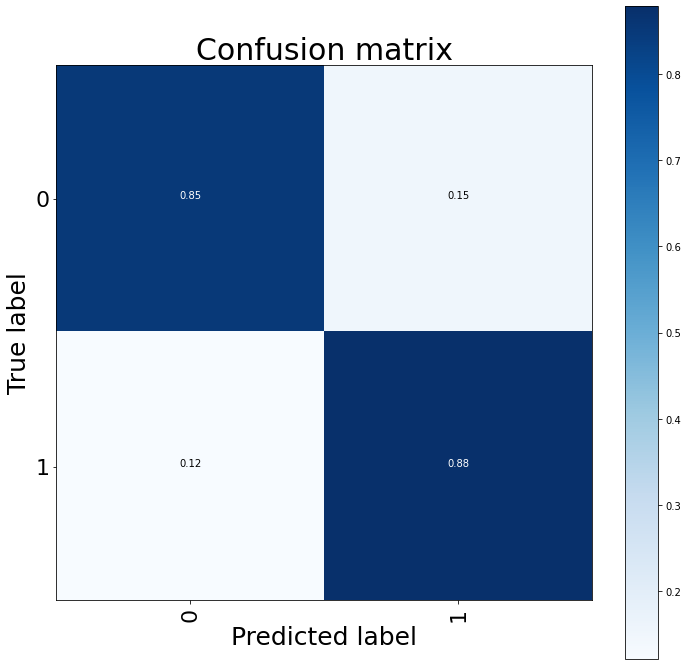

In [21]:
cnf_matrix = confusion_matrix(labellist, pred_list)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix")
plt.show()

In [22]:
print(classification_report(labellist, pred_list))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.85      0.88      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

